# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.5
IPython 6.4.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.0
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.19.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 1713c75514e589d2f19990a3c154b315cfe0642a


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from time import time

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../hw10/capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
#проверочная ячейка
X_sparse_10users.shape

(14061, 4913)

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [11]:
logit = LogisticRegression(random_state=17)

In [12]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
print(cross_val_score(logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean())

0.7610267543665875


In [14]:
print(accuracy_score(logit.predict(X_valid), y_valid))

0.7817018250770325


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [15]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, cv=skf, random_state=17, multi_class='multinomial')
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 1min 24s, sys: 8 s, total: 1min 32s
Wall time: 1min 22s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [16]:
logit_mean_cv_scores1 = np.mean(np.array(list(logit_grid_searcher1.scores_.values())[0]), axis=0)

In [17]:
logit_mean_cv_scores1

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75909731, 0.75625457, 0.7500573 , 0.73959139])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [18]:
max_score = max(logit_mean_cv_scores1)

In [19]:
best_C = logit_grid_searcher1.Cs[np.where(logit_mean_cv_scores1 == max_score)][0]

In [20]:
print(f'Best result: {max_score}, C: {best_C}')

Best result: 0.7590973132182534, C: 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

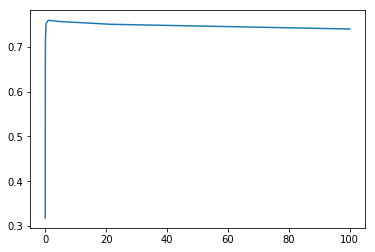

In [21]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [22]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, cv=skf, random_state=17, multi_class='multinomial')
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 4min 4s, sys: 15.7 s, total: 4min 20s
Wall time: 3min 58s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [23]:
logit_mean_cv_scores2 = np.mean(np.array(list(logit_grid_searcher2.scores_.values())[0]), axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [24]:
max_score = max(logit_mean_cv_scores2)

In [25]:
best_C = logit_grid_searcher1.Cs[np.where(logit_mean_cv_scores2 == max_score)][0]

In [26]:
print(f'Best result: {max_score}, C: {best_C}')

Best result: 0.7587913513956875, C: 0.00046415888336127773


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

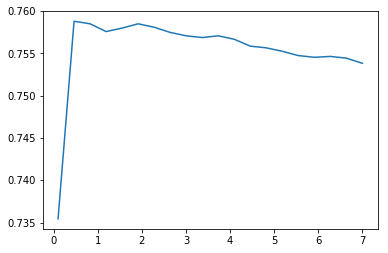

In [27]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [28]:
logit_best_C = LogisticRegression(random_state=17, C=best_C)
logit_best_C.fit(X_train, y_train)

LogisticRegression(C=0.00046415888336127773, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
logit_cv_acc = accuracy_score(logit_best_C.predict(X_valid), y_valid)
print(logit_cv_acc)

0.5375681441099787


**<font color='red'>Вопрос 1. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [30]:
%%time
logit_cv_best_c = LogisticRegressionCV(Cs=[best_C], random_state=17, multi_class='multinomial')
mean_cv = cross_val_score(logit_cv_best_c, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
acc_valid = accuracy_score(logit_best_C.predict(X_valid), y_valid)
print(round(mean_cv, 3), round(acc_valid, 3))

0.473 0.538
CPU times: user 279 ms, sys: 79 ms, total: 358 ms
Wall time: 4.89 s


**2. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [31]:
from sklearn.svm import LinearSVC

In [32]:
svm = LinearSVC(C=1, random_state=17)

In [33]:
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0)

In [34]:
print(cross_val_score(svm, X_valid, y_valid, scoring='accuracy', cv=skf, n_jobs=-1).mean())

0.713918114897675


In [35]:
print(accuracy_score(svm.predict(X_valid), y_valid))

0.7769613652524295


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [46]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 2min 36s, sys: 23.9 ms, total: 2min 36s
Wall time: 2min 36s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [47]:
print(f'C: {svm_grid_searcher1.best_params_}, best accurancy: {svm_grid_searcher1.best_score_}')

C: {'C': 6666.666700000001}, best accurancy: 0.6842105263157895


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

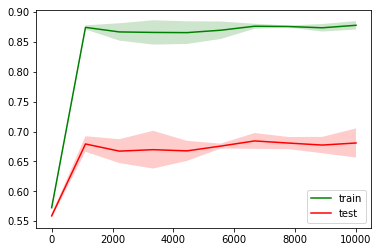

In [38]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [39]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 4min 19s, sys: 163 ms, total: 4min 19s
Wall time: 4min 19s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [40]:
print(f'C: {svm_grid_searcher2.best_params_}, best accurancy: {svm_grid_searcher2.best_score_}')

C: {'C': 0.10434482758620689}, best accurancy: 0.764681975208291


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

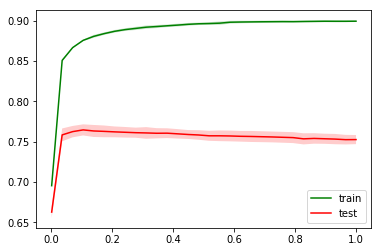

In [41]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [42]:
svm_best_C = LinearSVC(random_state=17, C=svm_grid_searcher2.best_params_['C'])
svm_best_C.fit(X_train, y_train)

LinearSVC(C=0.10434482758620689, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)

In [43]:
svm_cv_acc = accuracy_score(svm_best_C.predict(X_valid), y_valid)
print(svm_cv_acc)

0.7807537331121118


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [44]:
%%time
mean_cv = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
acc_valid = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)
print(round(mean_cv, 3), round(acc_valid, 3))

0.765 0.781
CPU times: user 178 ms, sys: 47.6 ms, total: 226 ms
Wall time: 2.19 s


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [65]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    start_time = time()
    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X_sparse_users = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y_users = pickle.load(y_users_pkl)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_users, y_users, test_size=test_size, 
                                                          random_state=random_state, stratify=y_users)
    model = estimator
    model.fit(X_train, y_train)
    mean_cv_accuracy = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
    accuracy_valid = accuracy_score(estimator.predict(X_valid), y_valid)
    return mean_cv_accuracy, accuracy_valid, time() - start_time

**Убедитесь, что функция работает.**

In [66]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7526960152920014, 0.7807537331121118, 8.981422901153564)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [45]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [46]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s{session_length}_w{window_size}.pkl')
        result = model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print(f'Session length: {session_length}, window_size: {window_size}, ' + 
              f'mean CV-accuracy for (X_train, y_train): {result[0]}, ' +
              f'accuracy for (X_valid, y_valid): {result[1]}, time: {result[2]}')

Session length: 15, window_size: 10, mean CV-accuracy for (X_train, y_train): 0.8074641824934817, accuracy for (X_valid, y_valid): 0.8404835269021095, time: 10.045058250427246
Session length: 10, window_size: 10, mean CV-accuracy for (X_train, y_train): 0.7526960152920014, accuracy for (X_valid, y_valid): 0.7807537331121118, time: 8.354961395263672
Session length: 15, window_size: 7, mean CV-accuracy for (X_train, y_train): 0.8379840883766031, accuracy for (X_valid, y_valid): 0.8543222166915547, time: 15.974298477172852
Session length: 10, window_size: 7, mean CV-accuracy for (X_train, y_train): 0.7908284673667915, accuracy for (X_valid, y_valid): 0.8073668491786958, time: 13.23484206199646
Session length: 7, window_size: 7, mean CV-accuracy for (X_train, y_train): 0.7475845126306272, accuracy for (X_valid, y_valid): 0.7617388418782147, time: 12.18013620376587
Session length: 15, window_size: 5, mean CV-accuracy for (X_train, y_train): 0.8670870557001469, accuracy for (X_valid, y_valid

**<font color='red'>Вопрос 3. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [47]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'), 'rb') as X_sparse_users_pkl:
    X_sparse_users = pickle.load(X_sparse_users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), 'rb') as y_users_pkl:
    y_users = pickle.load(y_users_pkl)
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_users, y_users, test_size=0.3, 
                                                      random_state=17, stratify=y_users)
mean_cv = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
acc_valid = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)
print(round(mean_cv, 3), round(acc_valid, 3))

0.868 0.839


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

Заметно, что чем меньше длина сессии, тем хуже модель предсказывает ответы. И наоборот,чем меньше ширина окна, тем больше доля правильных ответов. Выходит, чем больше строчек в нашей матрице, тем точнее ответы модели. что логично, ведь чем больше данных - тем лучше обучается модель.

In [48]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_150users_s{session_length}_w{window_size}.pkl')
    result = model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3)
    print(f'Session length: {session_length}, window_size: {window_size}, ' + 
          f'mean CV-accuracy for (X_train, y_train): {result[0]}, ' +
          f'accuracy for (X_valid, y_valid): {result[1]}, time: {result[2]}')

Session length: 5, window_size: 5, mean CV-accuracy for (X_train, y_train): 0.4081534771447957, accuracy for (X_valid, y_valid): 0.42171606560568453, time: 1880.9171285629272
Session length: 7, window_size: 7, mean CV-accuracy for (X_train, y_train): 0.4326334021764268, accuracy for (X_valid, y_valid): 0.45295840855673264, time: 1617.2338781356812
Session length: 10, window_size: 10, mean CV-accuracy for (X_train, y_train): 0.45053085335330817, accuracy for (X_valid, y_valid): 0.4836276942538802, time: 1136.5154144763947
CPU times: user 17min 53s, sys: 3.93 s, total: 17min 57s
Wall time: 1h 17min 14s


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [49]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_users_pkl:
    X_sparse_users = pickle.load(X_sparse_users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_users_pkl:
    y_users = pickle.load(y_users_pkl)
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_users, y_users, test_size=0.3, 
                                                      random_state=17, stratify=y_users)
mean_cv = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
acc_valid = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)
print(round(mean_cv, 3), round(acc_valid, 3))

0.461 0.484


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [50]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [51]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [52]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[best_C], random_state=17, multi_class='ovr', n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 1min 25s, sys: 43.9 s, total: 2min 9s
Wall time: 2min 33s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [53]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 6, CV score: 0.9878540021024644
User 13, CV score: 0.9957044505594775
User 15, CV score: 0.9944011666867908
User 16, CV score: 0.984715304975697
User 28, CV score: 0.987947407756819
User 31, CV score: 0.9944533146235649
User 33, CV score: 0.9925453323212979
User 39, CV score: 0.9839124943635006
User 46, CV score: 0.9971223873474009
User 49, CV score: 0.9938277466556086
User 50, CV score: 0.9941509394996083
User 53, CV score: 0.992044877946933
User 65, CV score: 0.9969243080969924
User 66, CV score: 0.9948599338027364
User 82, CV score: 0.9963508691796847
User 85, CV score: 0.9961944771876956
User 89, CV score: 0.9900743388478705
User 92, CV score: 0.9941509394996083
User 100, CV score: 0.9947452290691668
User 102, CV score: 0.9904392518824974
User 103, CV score: 0.9769999683175833
User 105, CV score: 0.9960172345434556
User 106, CV score: 0.9872175768475223
User 118, CV score: 0.990001354304928
User 119, CV score: 0.995944250000513
User 120, CV score: 0.9936609269174724
User 126, 

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [54]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (np.delete(class_distr, user_id).sum() / class_distr.sum() * 100)

In [55]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
print(num_better_than_default)

0


**<font color='red'>Вопрос 5. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [56]:
print((len(cv_scores_by_user) - num_better_than_default) / len(cv_scores_by_user) * 100)

100.0


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [57]:
tmp_y = y_train_150.astype('int')
y_binary_128 = np.where(tmp_y == 128, 1, 0)

In [58]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [59]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator = estimator, X = X_train_150, y = y_binary_128,
                                             cv = skf, n_jobs=-1)

CPU times: user 731 ms, sys: 181 ms, total: 912 ms
Wall time: 5.3 s


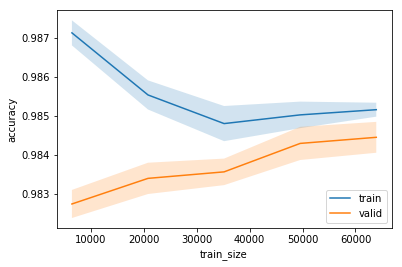

In [60]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

Я думаю, что да, потому что как видно с графика, чем больше выборка, на которой модель обучается, тем правильнее она отвечает на отложеной выборке. Так же видно, что на обучающей выборке она даёт результат хуже с увеличением размера выборки, но моё мнение, что так дуже лучше, ведь скорее всего, если она даёт большее количество правильных ответов на обучающей выборке лучше, чем на тестовой, значит она переобучилась. 